## Importing Libraries

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import dill
import datetime

## Importing Data

In [2]:
import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/Synthetic Data/Uncentered X/Bounded_Var_Time:2024-04-15 19:35:40, intercept:5,n_train:5000, n_test:1000, tensor_dimensions:[32 32], tensor_mode_ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
data = pickle.load(file)
file.close()

X_train_Full = data[0]
print(data[0].shape)

Y_train_Full = data[1]
print(data[1].shape)

X_test_Full = data[2]
print(data[2].shape)

Y_test_Full = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)


## Setting up Global Parameters

### 1. Tensor Parameters

In [3]:
#importing path 
import sys
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/CodeFiles')

#parameters related to tensor

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2

### 2. Preprocessing Pipeline

In [4]:
n_train = 650
n_test = 100

#Subset X_train and Y_train
X_train = X_train_Full[0:(n_train),:,:]
Y_train = Y_train_Full[0:(n_train)]

#Subset X_test and Y_test
X_test = X_test_Full[0:(n_test),:,:]
Y_test = Y_test_Full[0:(n_test)]


#Preprocessing

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)


X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)


# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, tensor_dimensions[0],tensor_dimensions[1])
X_test  = X_test_scaled.reshape(n_test, tensor_dimensions[0],tensor_dimensions[1])

#average response value
Y_train_mean = np.mean(Y_train)
#Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)


Sample mean for each feature (across samples): [4.99871322 4.98420917 5.00873521 ... 5.01840176 4.98600789 5.01023623]
Sample variance for each feature (across samples): None
Response Average: 83.56008733093063


In [5]:
# intializing the tensor object 
from LSR_Tensor_2D_v1 import LSR_tensor_dot

hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}

ranks = hypers['ranks']
separation_rank = hypers['separation_rank']
LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
need_intercept = False

lsr_tensor_CL = LSR_tensor_dot(shape = LSR_tensor_dot_shape, ranks = ranks, separation_rank = separation_rank, intercept = need_intercept)

#keeping a copy of the orginal object
import copy
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_CL)
lsr_tensor_GD = copy.deepcopy(lsr_tensor_CL)
lsr_tensor_initializer = copy.deepcopy(lsr_tensor_CL)

#regularization parameter

lambda1 = 50


intercept is not initialized


In [6]:
#saving the initializer
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/Initializers_ExecutionTime_intercept_5_{formatted_time}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}.pkl"

with open(pkl_file, "wb") as file:
      dill.dump((lsr_tensor_initializer), file)

## Closed-Form Solver

In [7]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_closed import lsr_bcd_regression
from optimization_closed import inner_product, R2, objective_function_vectorized

def train_test(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, B_tensored: np.ndarray,lsr_tensor_CL,lambda1, hypers,Y_train_mean, intercept = False):
  hypers['weight_decay'] = lambda1

  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_CL
  lsr_tensor, objective_function_values = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')

  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean


  print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  print("Y Test Predicted: ", Y_test_predicted.flatten())
  print("Y Test Actual: ", Y_test.flatten())

  return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values


In [8]:
#hyper parameters

normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values = train_test(X_train, Y_train, X_test, Y_test, B_tensored,lsr_tensor_CL, lambda1, hypers, Y_train_mean,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/Closed_form_Data_ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

with open(pkl_file, "wb") as file:
      dill.dump((lambda1, normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values), file)

Separable Function
Objective Function Value: 5529543.826977203
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separa

## Gradient Descent 

In [9]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_gd import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_gd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_GD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_GD
  lsr_tensor, objective_function_values, gradient_values = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  #print("Y Test Predicted: ", Y_test_predicted.flatten())
  #print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values



In [10]:
learning_rate = None 
epochs = 100
batch_size = None

hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}

normalized_estimation_error_GD, test_nmse_loss_GD, test_R2_loss_GD, test_correlation_GD, objective_function_values_GD,gradient_values_GD = train_test_gd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_GD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/Gradient_Descent_ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("GD_Alpha chosen for model: ", lambda1)
print("GD_Test Normalized Estimation Error: ", normalized_estimation_error_GD)
print("GD_Test NMSE Loss: ", test_nmse_loss_GD)
print("GD_Test R2 Loss: ", test_R2_loss_GD)
print("GD_Test Correlation: ", test_correlation_GD)

with open(pkl_file, "wb") as file:
  dill.dump((lambda1, normalized_estimation_error_GD, test_nmse_loss_GD, test_R2_loss_GD, test_correlation_GD, objective_function_values_GD), file)

Separable Function
Objective Function Value: 5529543.826977203
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Value of t is: 1.515904002188725e-05
Gradient Norm for linear.weight: 209300.8125
Value of t is: 1.7659769942956235e-05
Gradient Norm for linear.weight: 105782.078125
Value of t is: 1.4367540542837185e-05
Gradient Norm for linear.weight: 79947.546875
Value of t is: 1.7327431834608757e-05
Gradient Norm for linear.weight: 53605.8203125
Value of t is: 1.4472446706431995e-05
Gradient Norm for linear.weight: 45633.2265625
Value of t is: 1.7596390137275762e-05
Gradient Norm for linear.weight: 33434.234375
Value of t is: 1.4665306777632875e-05
Gradient Norm for linear.weight: 30341.4296875
Value of t is: 1.787658711223154e-05
Gradient Norm for linear.weight: 23306.62890625
Value of t 

## Stochastic Solver

### 1. Train Test Function

In [10]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_sgd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_SGD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_SGD
  lsr_tensor, objective_function_values, gradient_values,iterate_differences,epoch_level_gradients = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  #print("Y Test Predicted: ", Y_test_predicted.flatten())
  #print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_differences,epoch_level_gradients



### 2. Block 1 Evaluation

In [13]:
#loading previous initializer

#Loading the checkpoints

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/Initializers_ExecutionTime_intercept_5_2024-05-30 16:03:03, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
lsr_tensor_initializer = pickle.load(file)
file.close()


In [14]:
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_initializer )
learning_rate = 0.000005
epochs = 100
batch_size = 64

momentum = 0
nesterov = False

hypers = {'max_iter': 15, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov}

normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD,iterate_differences_SGD,epoch_level_gradients_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Tensor_Method/Finding Lamda for Test/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"


#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD_ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

with open(pkl_file, "wb") as file:
  dill.dump((lsr_tensor_SGD,lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD, iterate_differences_SGD,epoch_level_gradients_SGD), file)


print("Error Report on Testing _ With best Lambda")
print("SGD_Alpha chosen for model: ", lambda1)
print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
print("SGD_Test Correlation: ", test_correlation_SGD)



Separable Function
Objective Function Value: 5529543.826977203
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------
Epoch [1/100], Loss: 2151320.7500, Gap to Optimality: 2151320.7500, NMSE: 0.9377574920654297, Correlation: 0.36027969452700137, R2: 0.062242517463667824
Epoch [2/100], Loss: 2056756.2500, Gap to Optimality: 2056756.2500, NMSE: 0.8965020179748535, Correlation: 0.3942970219063926, R2: 0.10349791467820157
Epoch [3/100], Loss: 1997367.3750, Gap to Optimality: 1997367.3750, NMSE: 0.8705735206604004, Correlation: 0.40879325157797375, R2: 0.12942647063479884
Epoch [4/100], Loss: 1955955.7500, Gap to Optimality: 1955955.7500, NMSE: 0.8524793982505798, Correlation: 0.41967202499467965, R2: 0.14752063709324692
Epoch [5/100], Loss: 1925368.8750, Gap to Optimality: 1925368.8750, NMSE: 0.83

In [48]:
#Loading the checkpoints

import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/Data/SGD_ExecutionTime_intercept_5_2024-05-30 20:10:38, n_train_650,n_test_100, tensor_dimensions:[32 32], tensor_mode_= ranks:[4 4], separation_rank:2, max_iter=15.pkl"
file= open(pkl_file, 'rb')
checkpoint_data = pickle.load(file)
file.close()

lsr_tesnsor_SGD = checkpoint_data[0]
objective_function_values_SGD__loaded = checkpoint_data[11]
print(objective_function_values_SGD_1.shape)


(15, 1)


In [49]:
#Copying initializer just in case 

lsr_tensor_SGD_intermediate = copy.deepcopy(lsr_tensor_SGD)

### 4. Block 2 If Needed

Separable Function
Objective Function Value: 96370.50060959972
--------------------------------------------------------------BCD iteration 0 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


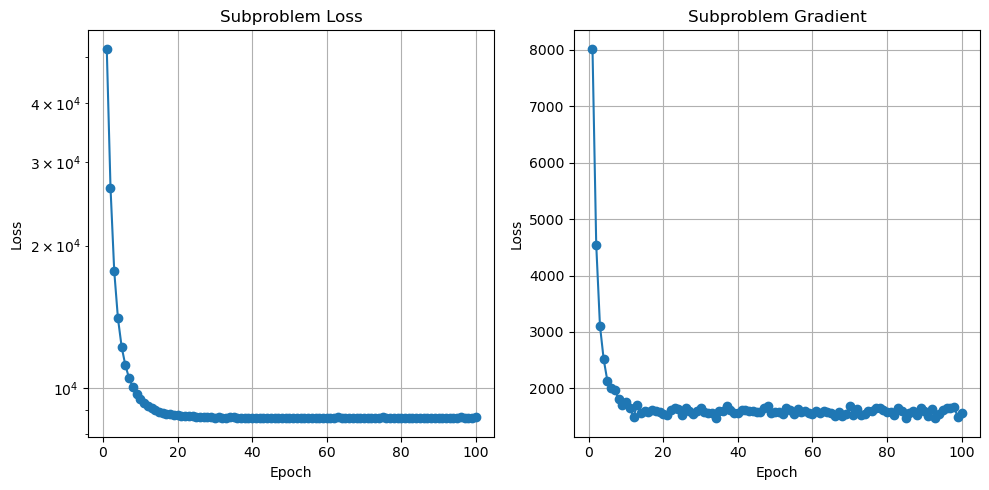

Final gradient of the subproblem (0, 0) : 1559.834716796875
Separable Function
Iteration: 0, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96148.9464851651
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


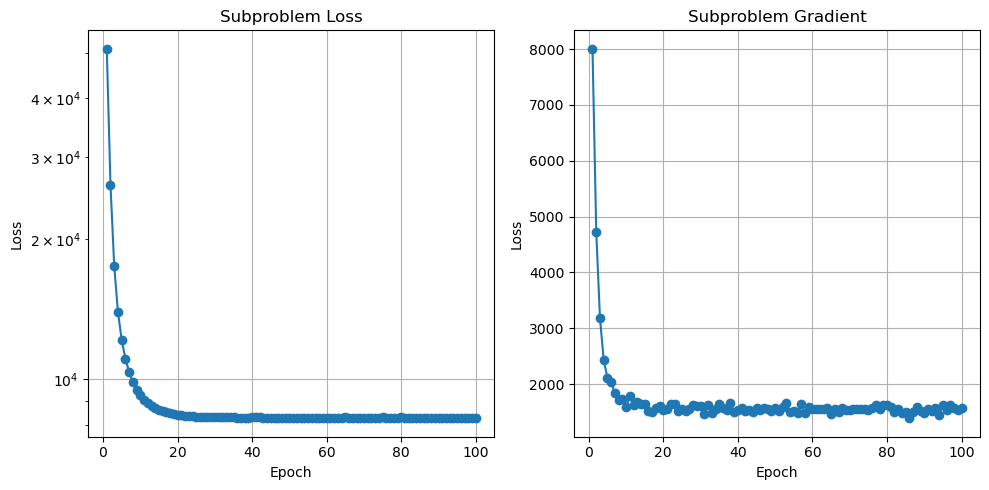

Final gradient of the subproblem (0, 1) : 1564.19189453125
Separable Function
Iteration: 0, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95680.03339819699
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


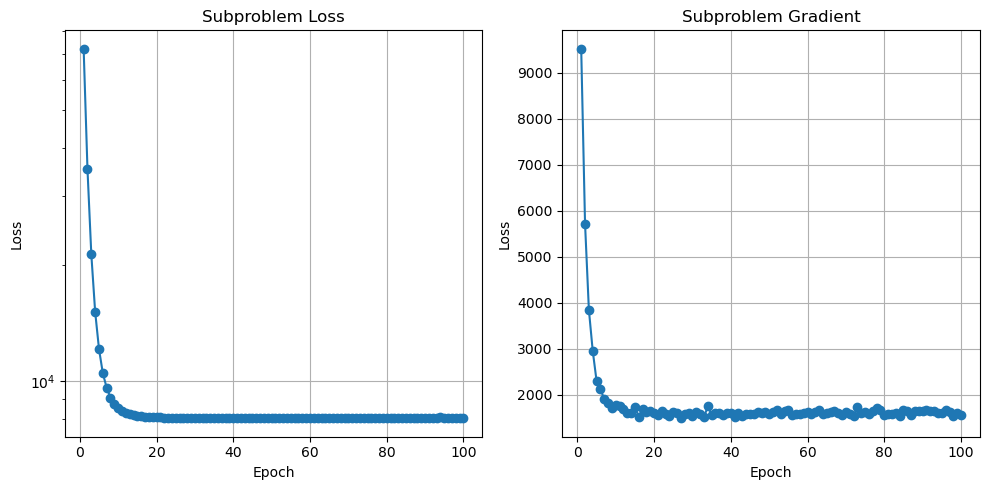

Final gradient of the subproblem (1, 0) : 1556.0828857421875
Separable Function
Iteration: 0, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 96197.93792292253
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


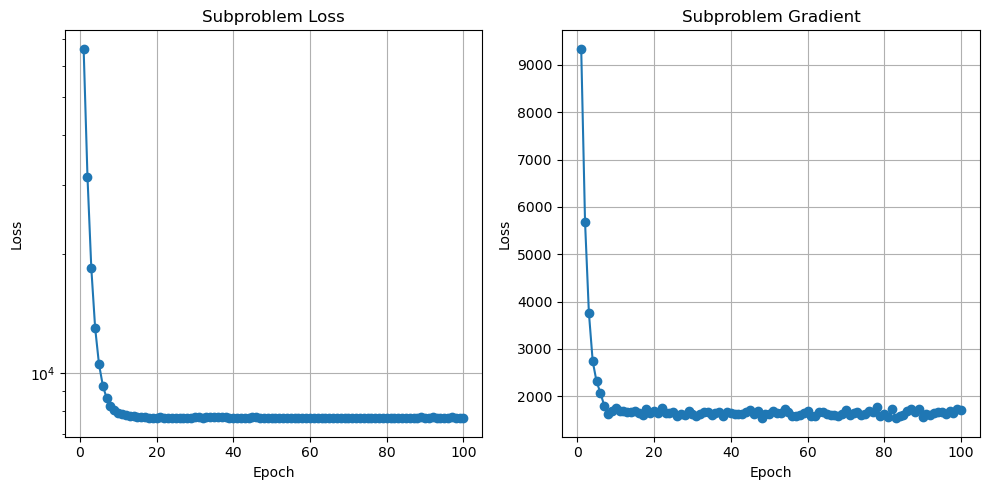

Final gradient of the subproblem (1, 1) : 1699.4461669921875
Separable Function
Iteration: 0, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95975.64320869514
---------------------------------------------Core-------------------------------------------------


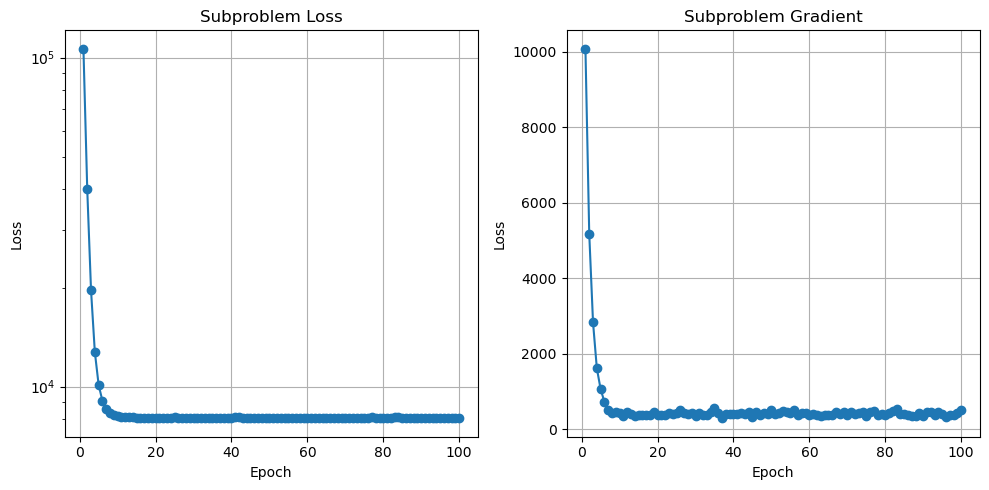

Final gradient of the subproblem Core : 517.2387084960938
Separable Function
--------------------------------------------------------------BCD iteration 1 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


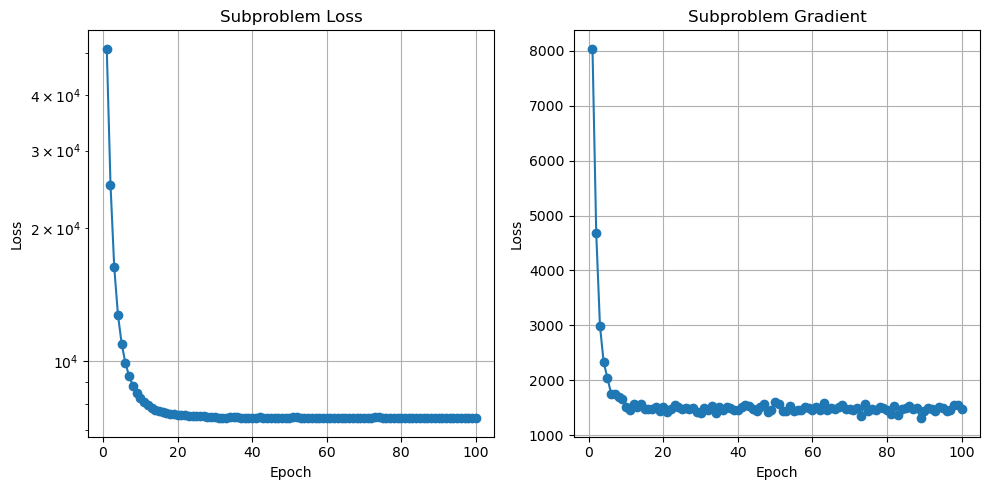

Final gradient of the subproblem (0, 0) : 1484.2242431640625
Separable Function
Iteration: 1, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96074.22464070364
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


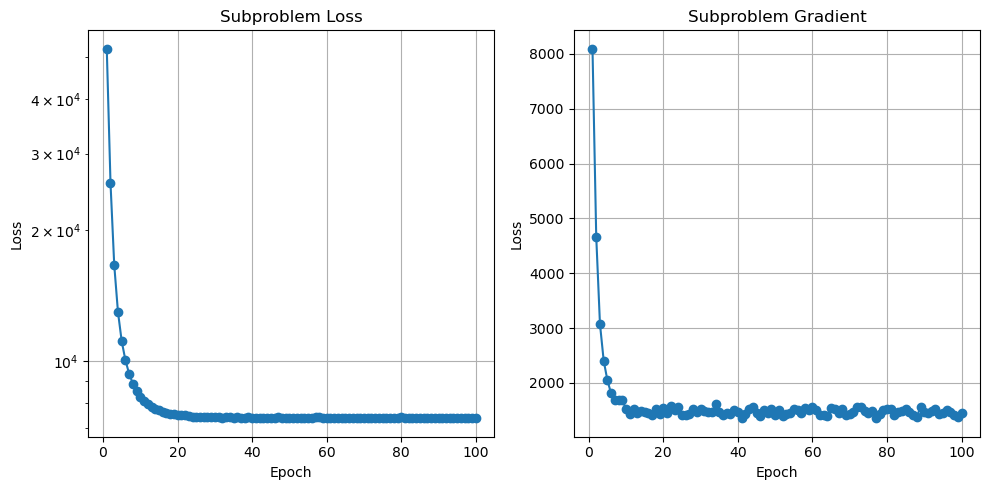

Final gradient of the subproblem (0, 1) : 1451.571044921875
Separable Function
Iteration: 1, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95821.37606838717
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


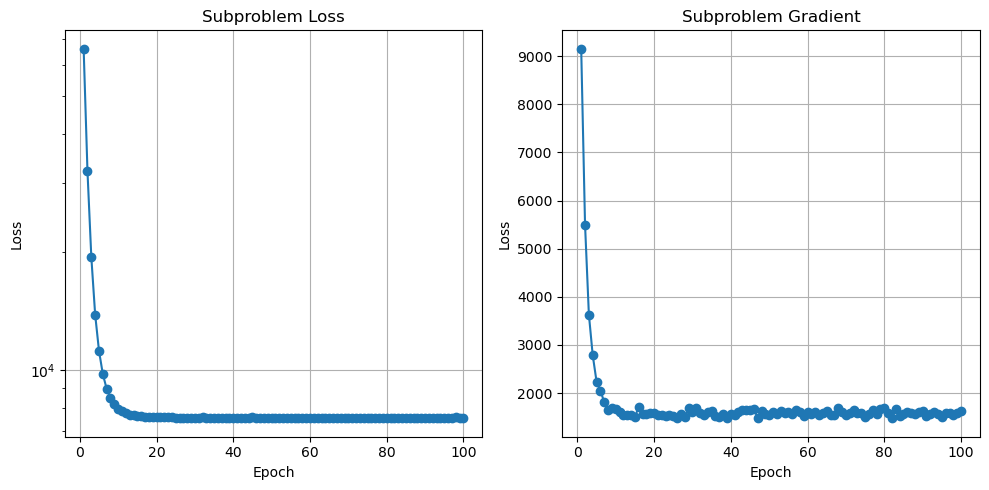

Final gradient of the subproblem (1, 0) : 1633.04541015625
Separable Function
Iteration: 1, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95663.00935006065
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


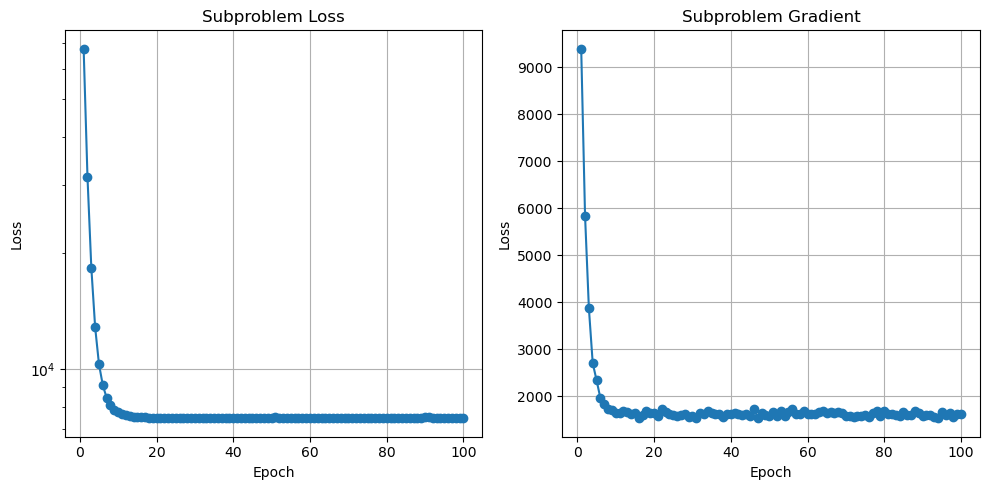

Final gradient of the subproblem (1, 1) : 1621.1658935546875
Separable Function
Iteration: 1, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95854.06725849907
---------------------------------------------Core-------------------------------------------------


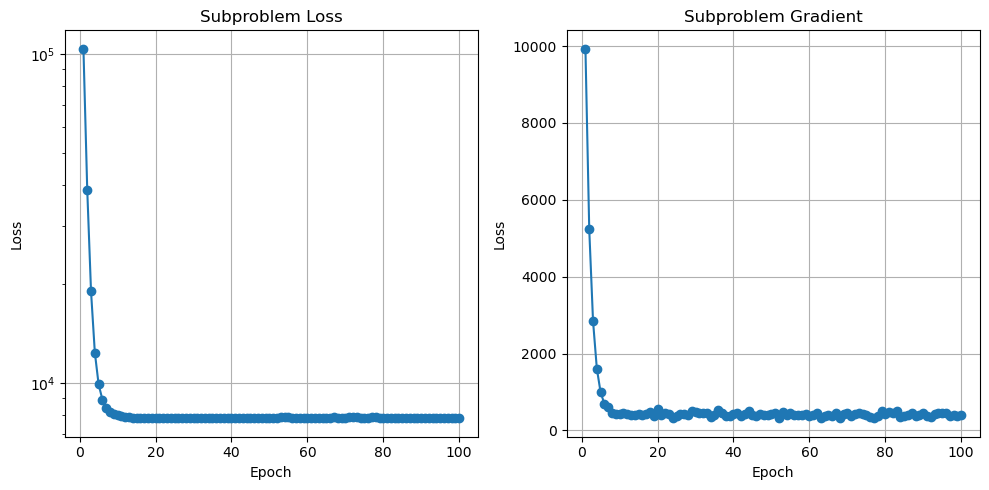

Final gradient of the subproblem Core : 411.2797546386719
Separable Function
--------------------------------------------------------------BCD iteration 2 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


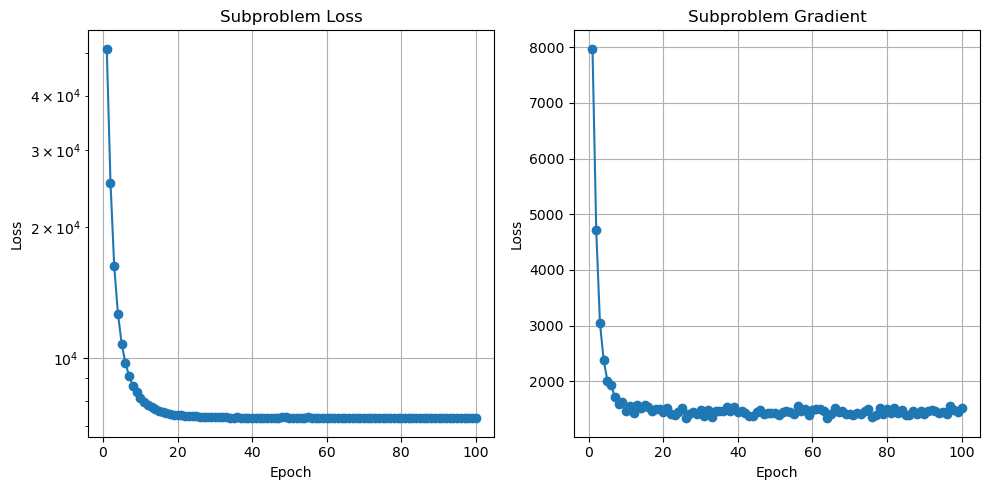

Final gradient of the subproblem (0, 0) : 1516.2265625
Separable Function
Iteration: 2, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 95994.46689810854
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


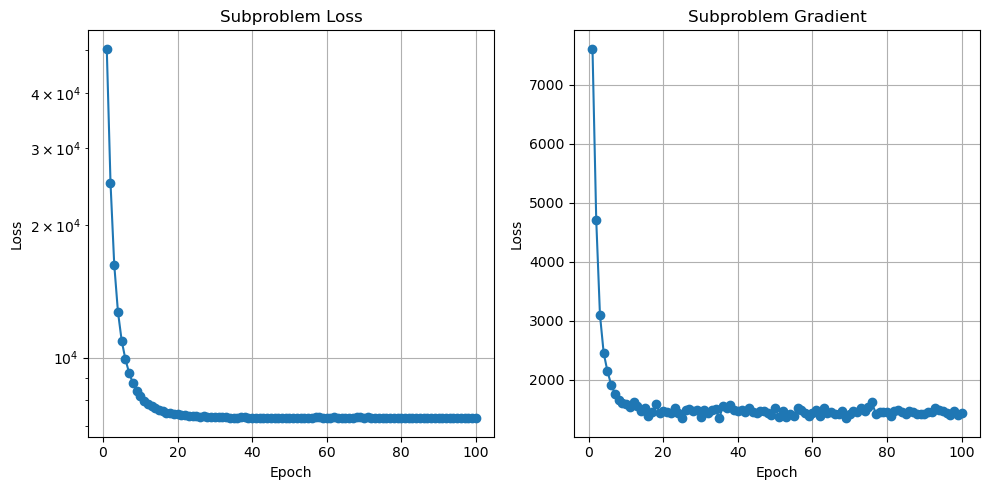

Final gradient of the subproblem (0, 1) : 1425.8255615234375
Separable Function
Iteration: 2, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95866.92316852752
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


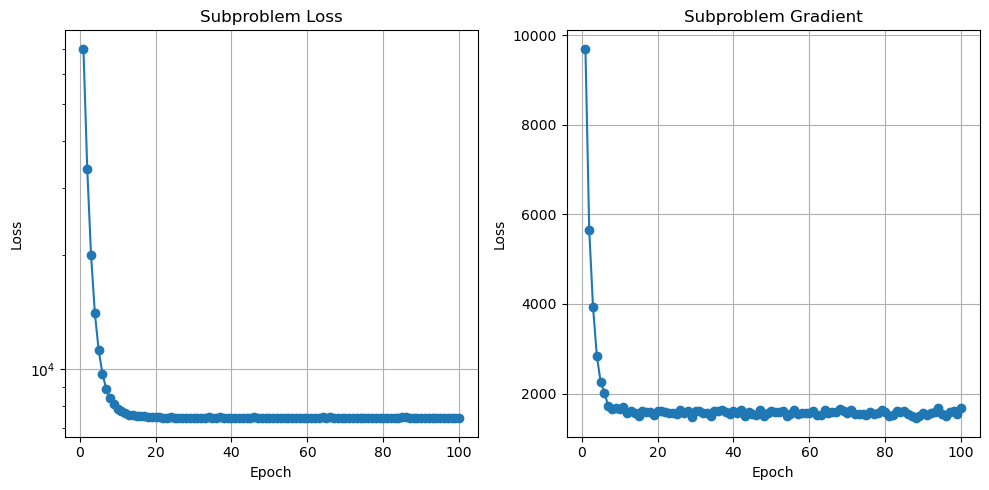

Final gradient of the subproblem (1, 0) : 1667.57861328125
Separable Function
Iteration: 2, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95912.85972969254
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


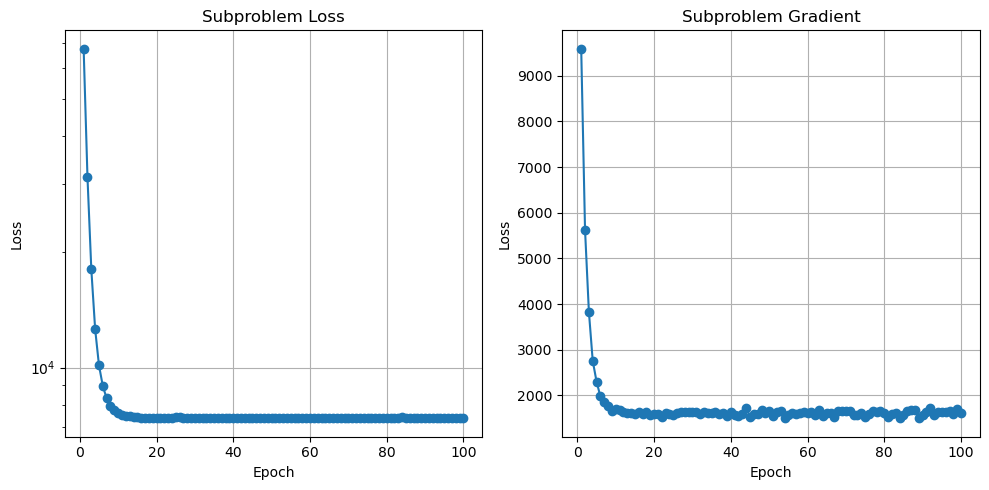

Final gradient of the subproblem (1, 1) : 1621.104736328125
Separable Function
Iteration: 2, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 96150.84403935366
---------------------------------------------Core-------------------------------------------------


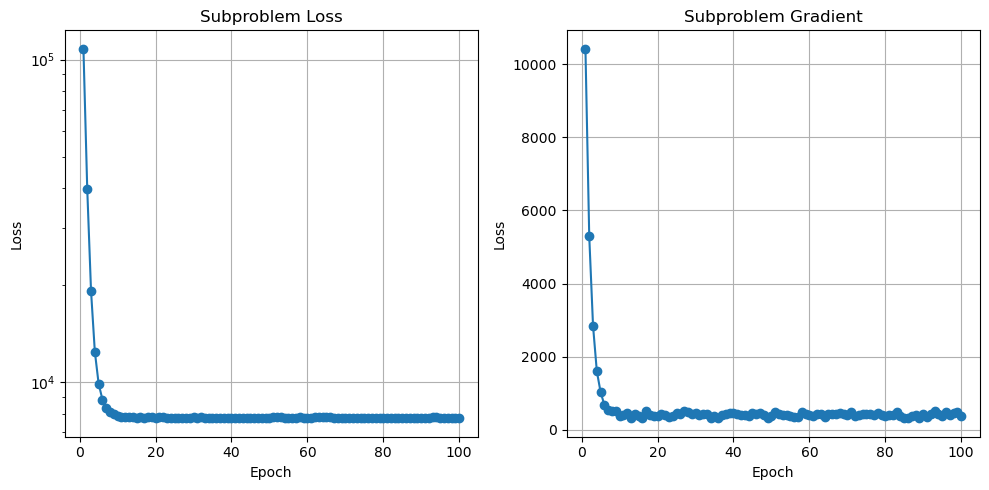

Final gradient of the subproblem Core : 383.1458740234375
Separable Function
--------------------------------------------------------------BCD iteration 3 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


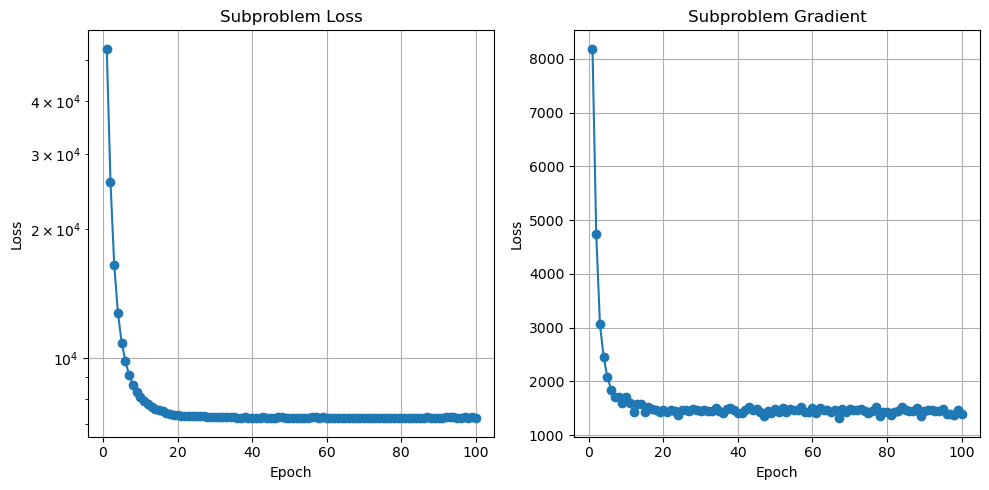

Final gradient of the subproblem (0, 0) : 1391.4892578125
Separable Function
Iteration: 3, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96087.72802036337
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


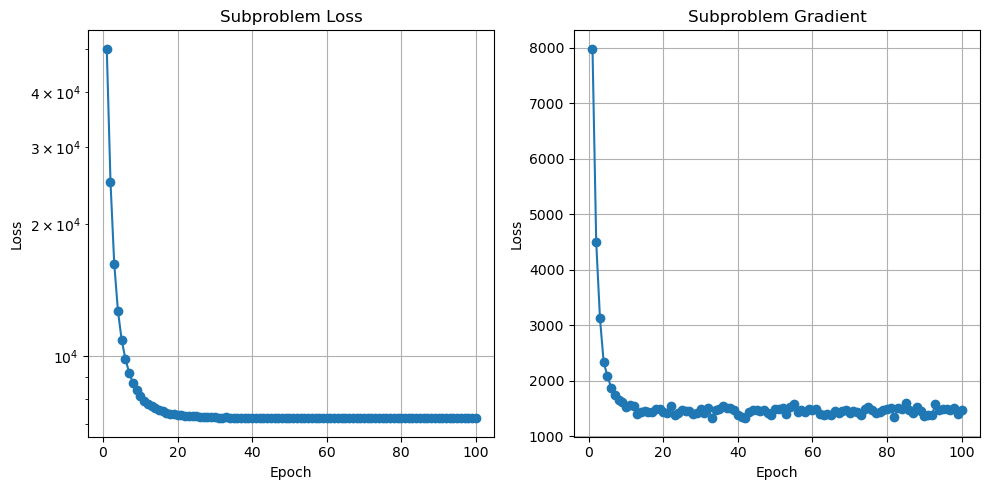

Final gradient of the subproblem (0, 1) : 1475.9305419921875
Separable Function
Iteration: 3, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95987.26963398085
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


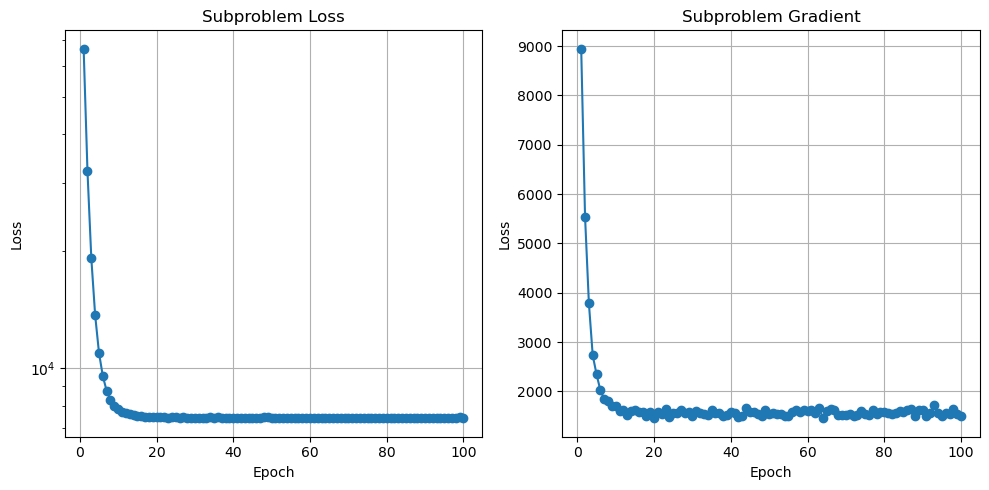

Final gradient of the subproblem (1, 0) : 1511.0948486328125
Separable Function
Iteration: 3, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95791.22195044548
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


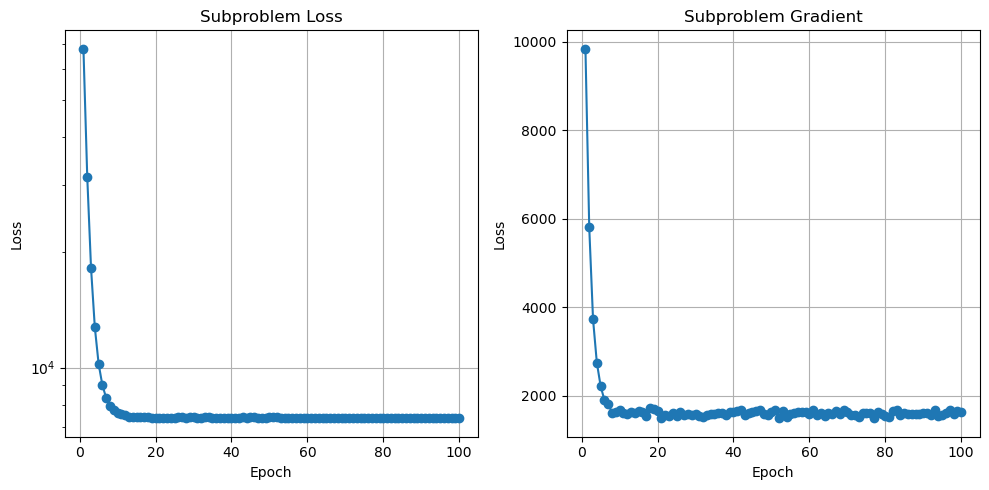

Final gradient of the subproblem (1, 1) : 1640.86328125
Separable Function
Iteration: 3, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95935.68624539068
---------------------------------------------Core-------------------------------------------------


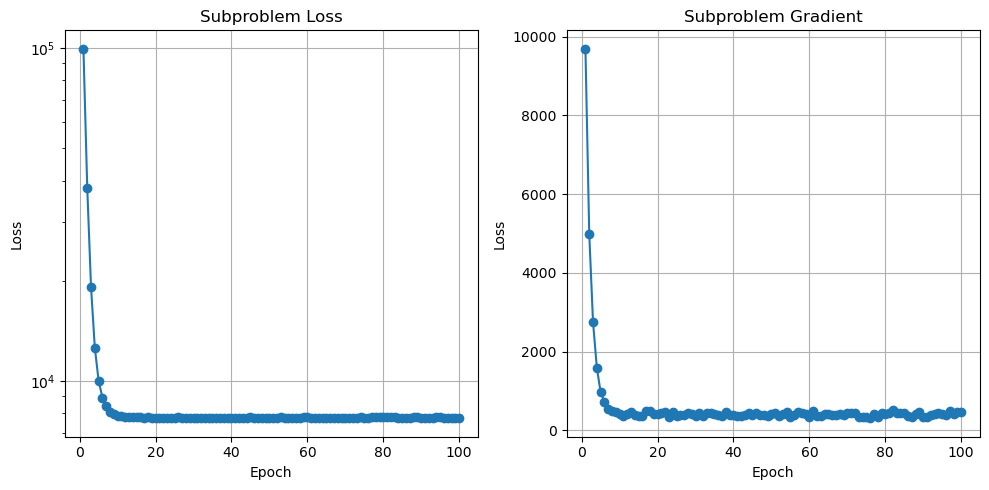

Final gradient of the subproblem Core : 477.02716064453125
Separable Function
--------------------------------------------------------------BCD iteration 4 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


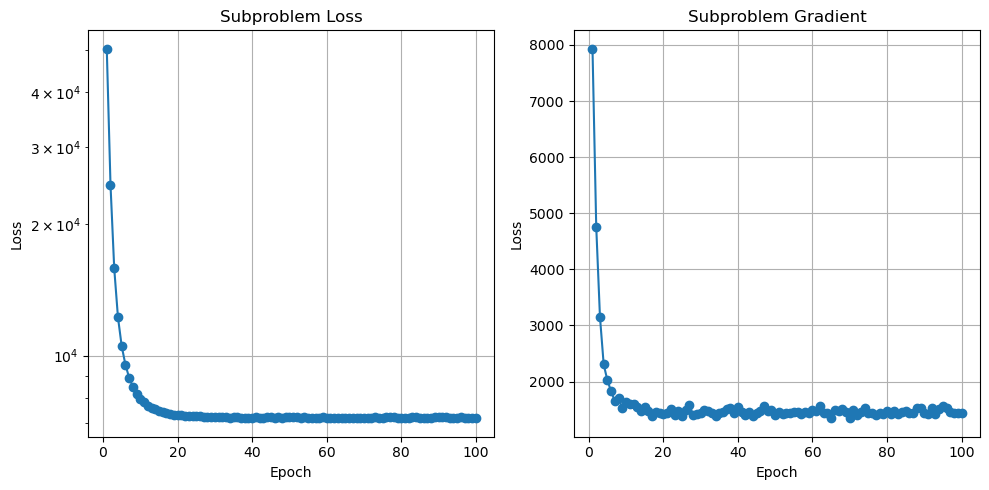

Final gradient of the subproblem (0, 0) : 1438.2978515625
Separable Function
Iteration: 4, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96232.6617288784
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


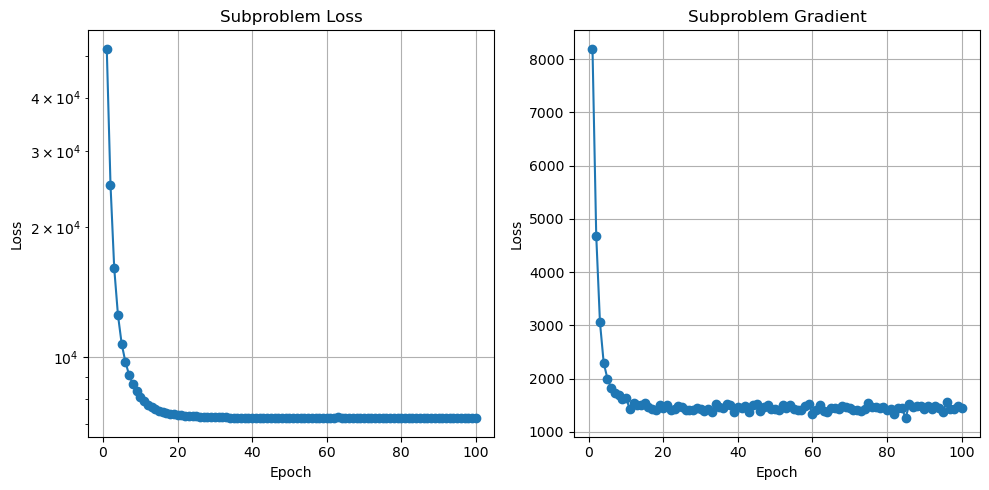

Final gradient of the subproblem (0, 1) : 1447.3240966796875
Separable Function
Iteration: 4, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 96077.04779917147
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


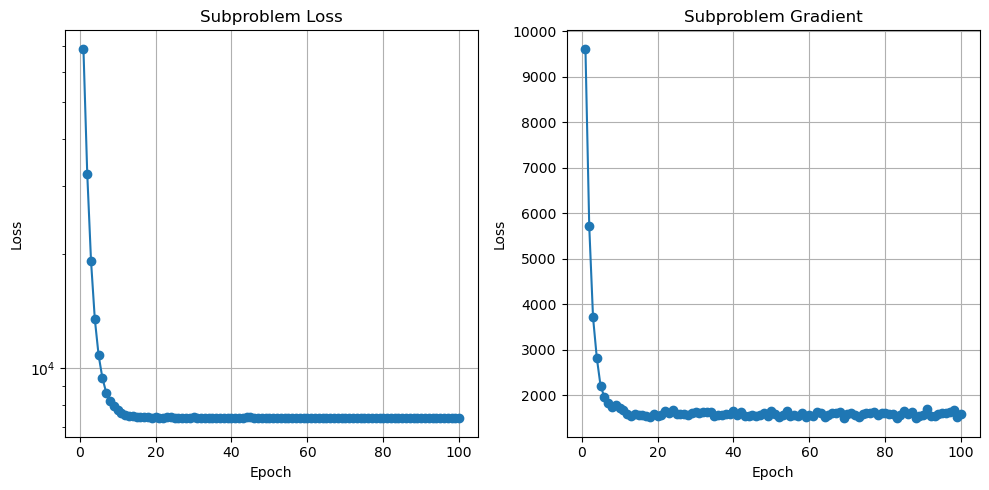

Final gradient of the subproblem (1, 0) : 1574.6171875
Separable Function
Iteration: 4, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95908.80590336882
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


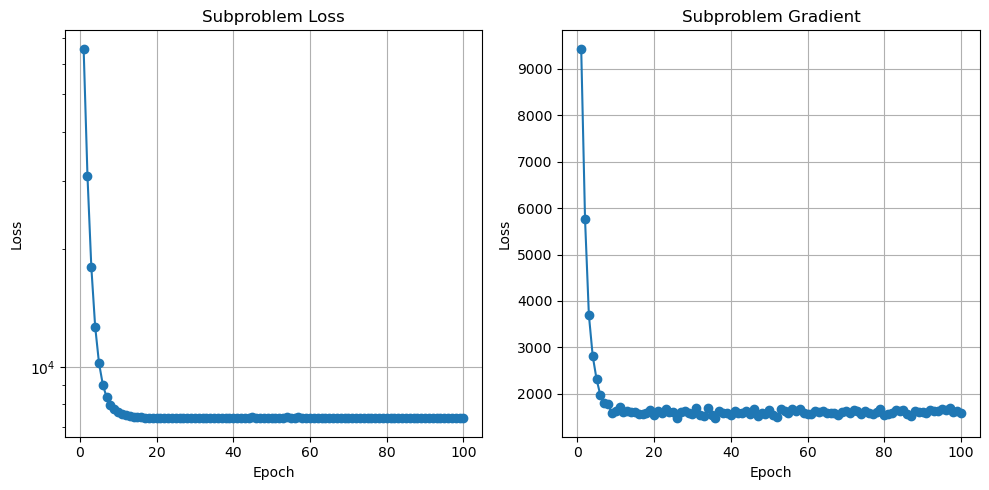

Final gradient of the subproblem (1, 1) : 1593.8109130859375
Separable Function
Iteration: 4, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95792.11968776514
---------------------------------------------Core-------------------------------------------------


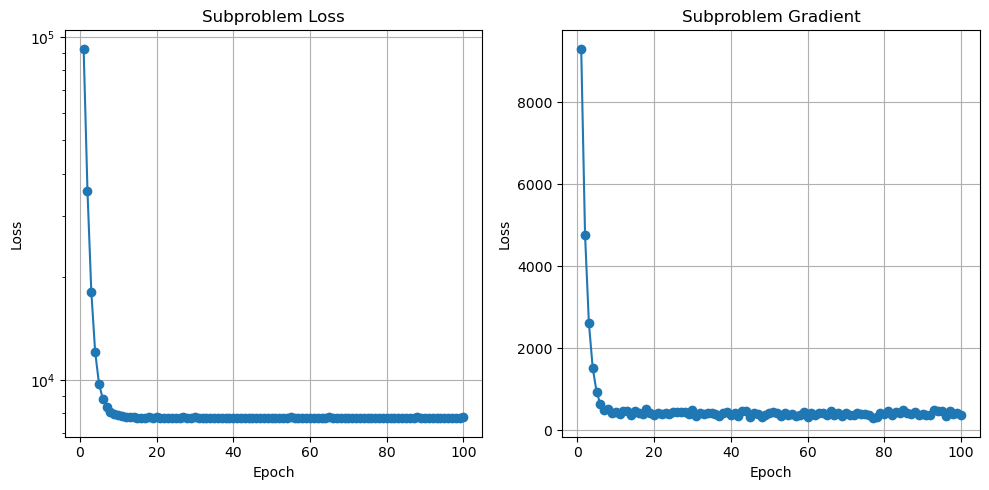

Final gradient of the subproblem Core : 374.2370300292969
Separable Function
--------------------------------------------------------------BCD iteration 5 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


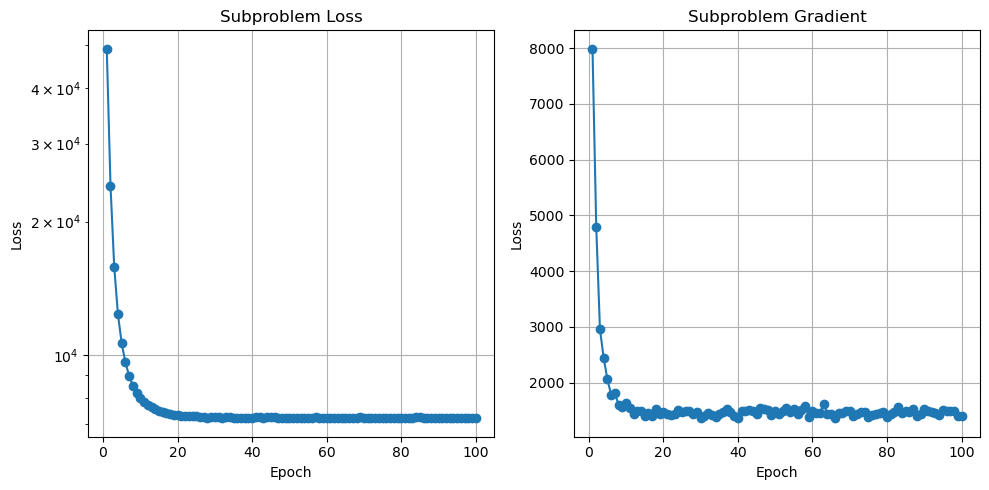

Final gradient of the subproblem (0, 0) : 1402.2286376953125
Separable Function
Iteration: 5, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 95971.86910088424
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


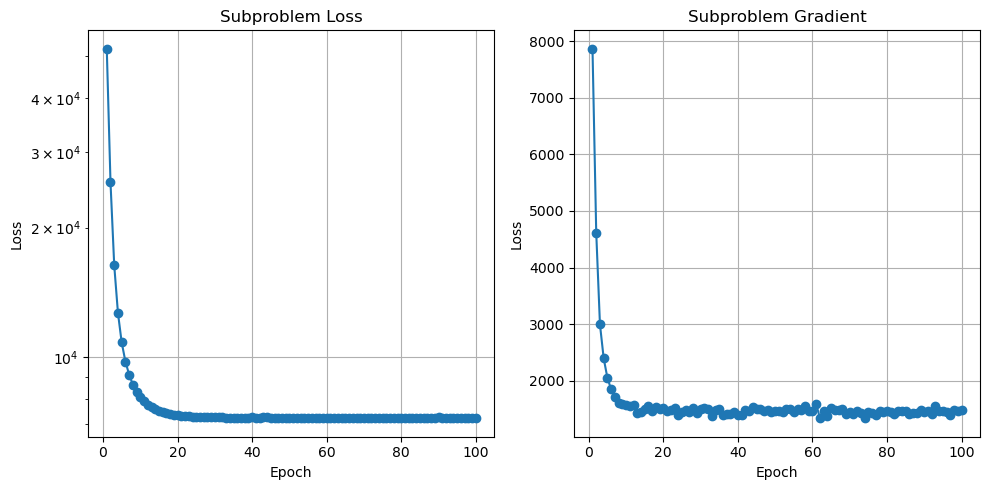

Final gradient of the subproblem (0, 1) : 1486.1260986328125
Separable Function
Iteration: 5, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95973.70245478912
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


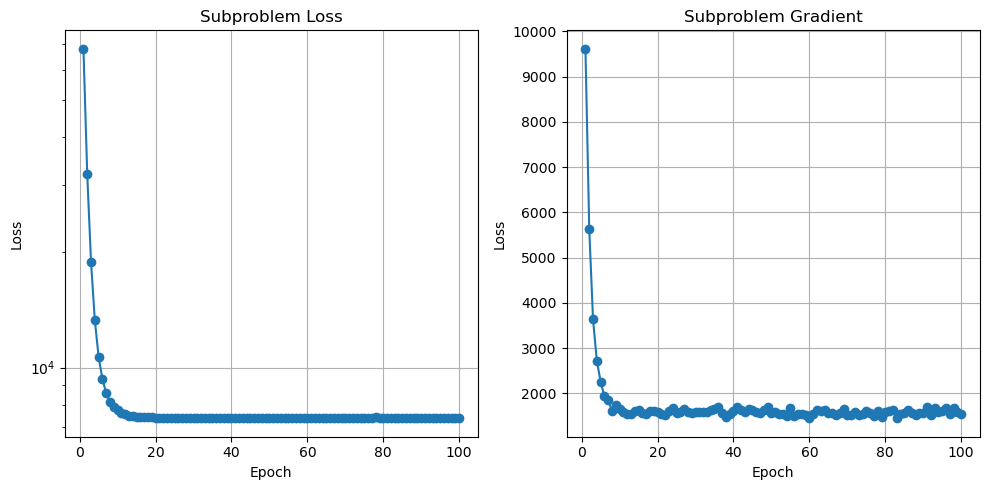

Final gradient of the subproblem (1, 0) : 1540.29296875
Separable Function
Iteration: 5, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95943.36368176546
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


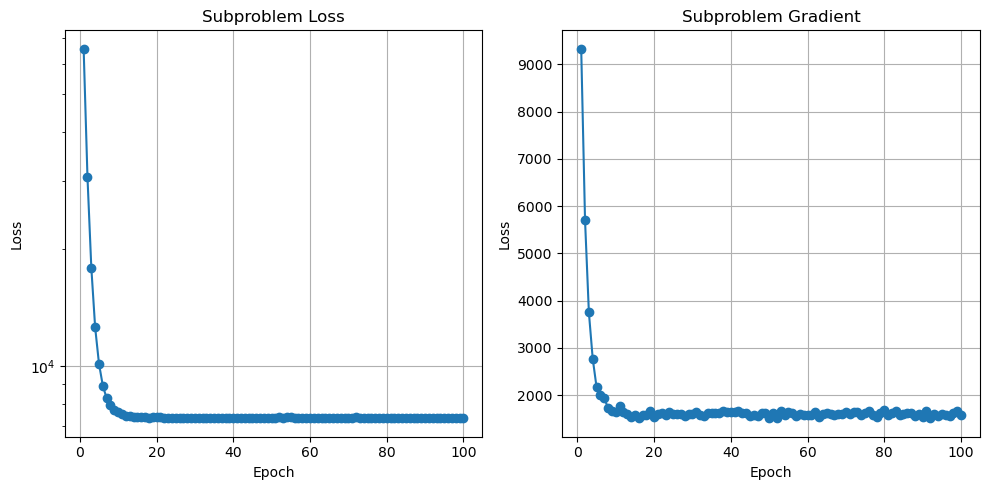

Final gradient of the subproblem (1, 1) : 1579.227783203125
Separable Function
Iteration: 5, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 96010.07197896055
---------------------------------------------Core-------------------------------------------------


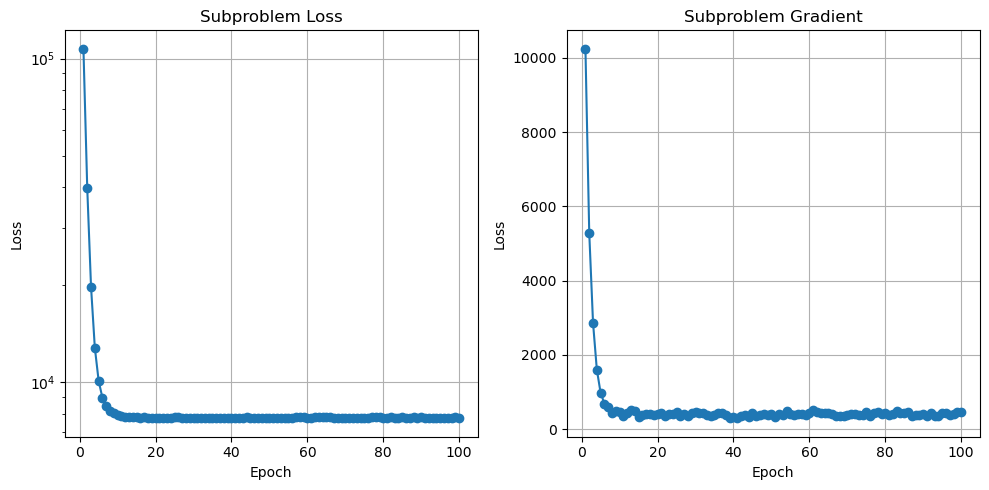

Final gradient of the subproblem Core : 467.26580810546875
Separable Function
--------------------------------------------------------------BCD iteration 6 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


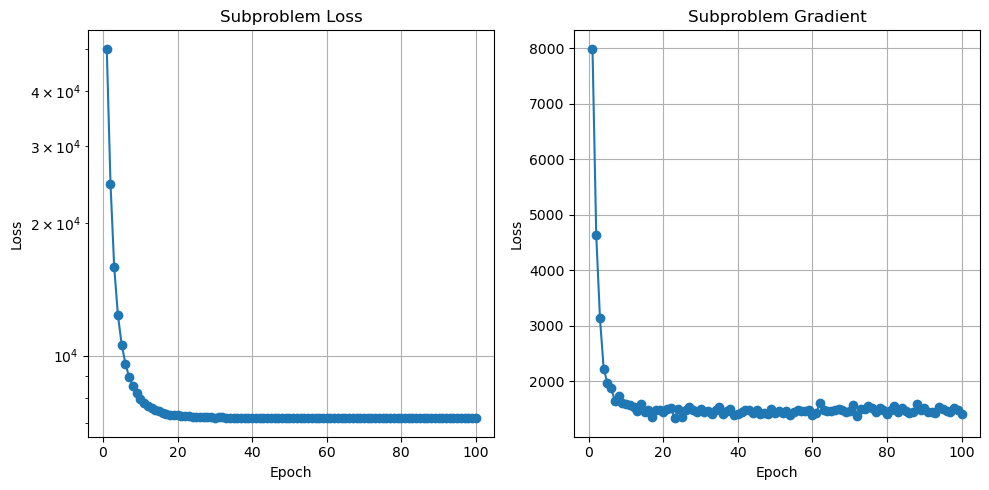

Final gradient of the subproblem (0, 0) : 1413.98388671875
Separable Function
Iteration: 6, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96165.41371502489
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


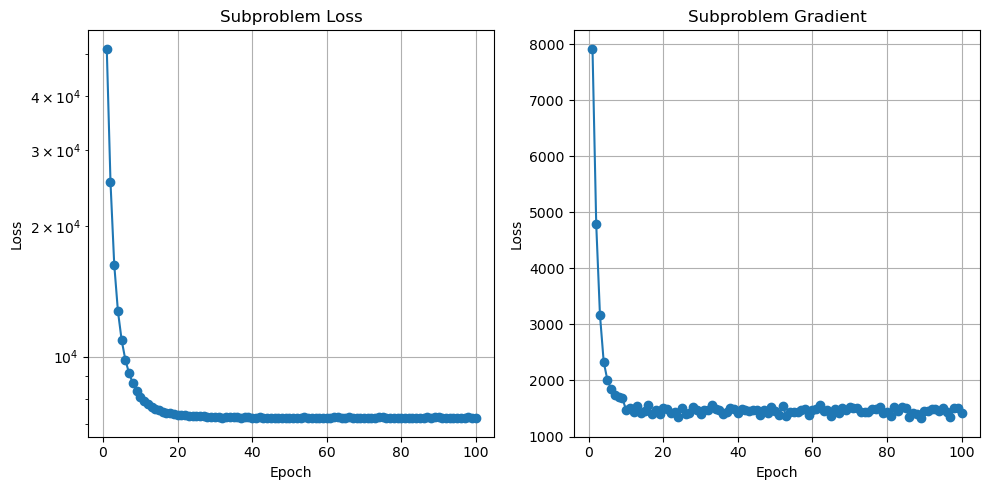

Final gradient of the subproblem (0, 1) : 1423.091064453125
Separable Function
Iteration: 6, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95973.85895170645
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


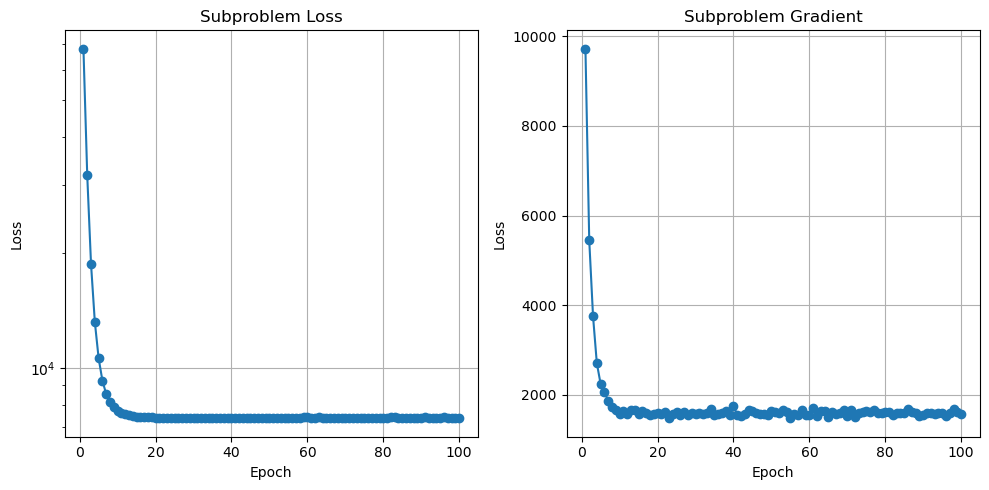

Final gradient of the subproblem (1, 0) : 1574.0421142578125
Separable Function
Iteration: 6, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95939.09532640407
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


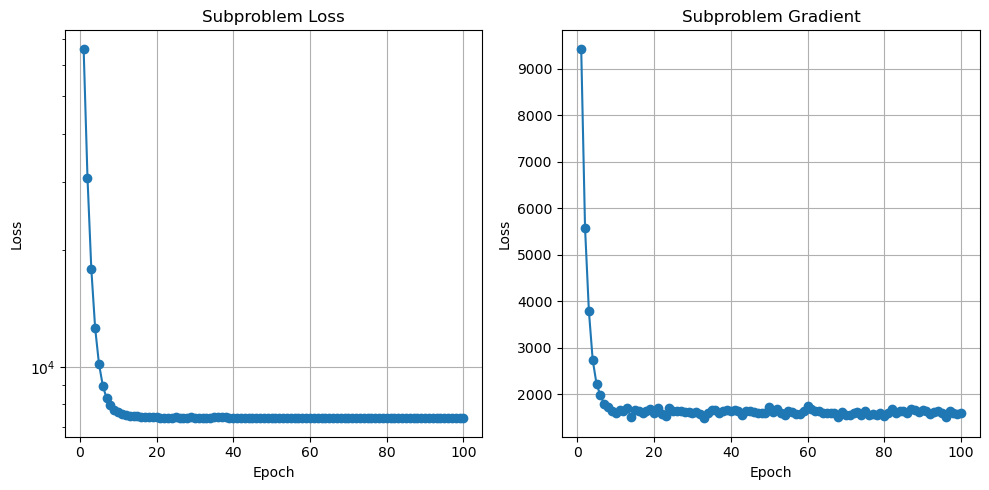

Final gradient of the subproblem (1, 1) : 1586.8475341796875
Separable Function
Iteration: 6, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95815.35198960887
---------------------------------------------Core-------------------------------------------------


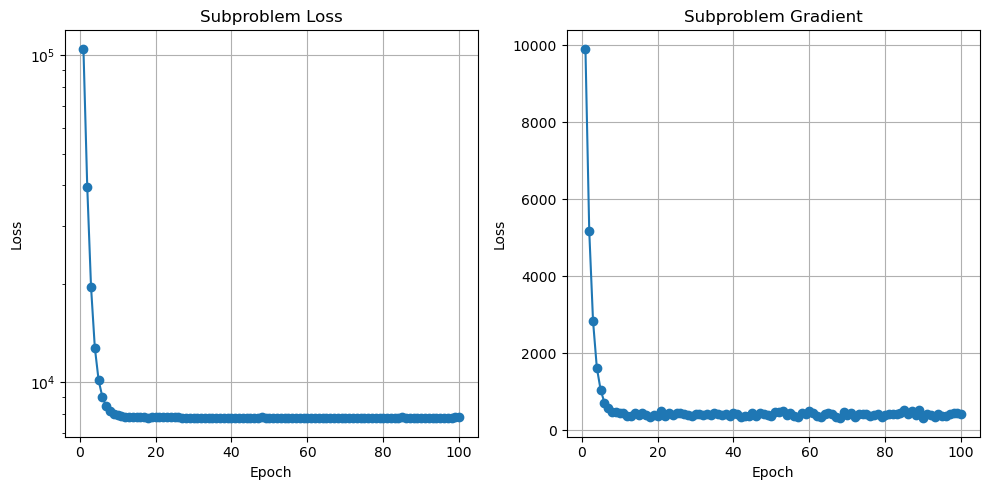

Final gradient of the subproblem Core : 423.35516357421875
Separable Function
--------------------------------------------------------------BCD iteration 7 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


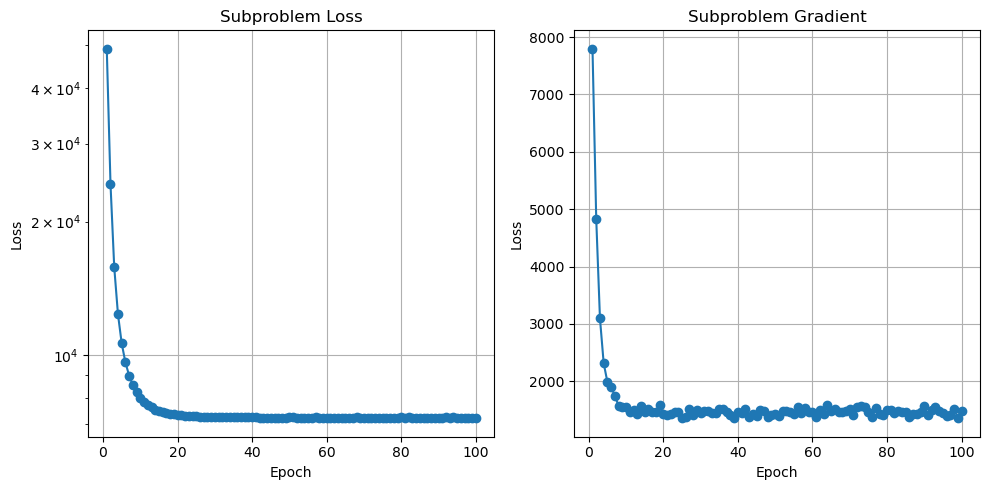

Final gradient of the subproblem (0, 0) : 1489.2664794921875
Separable Function
Iteration: 7, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96012.71320311213
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


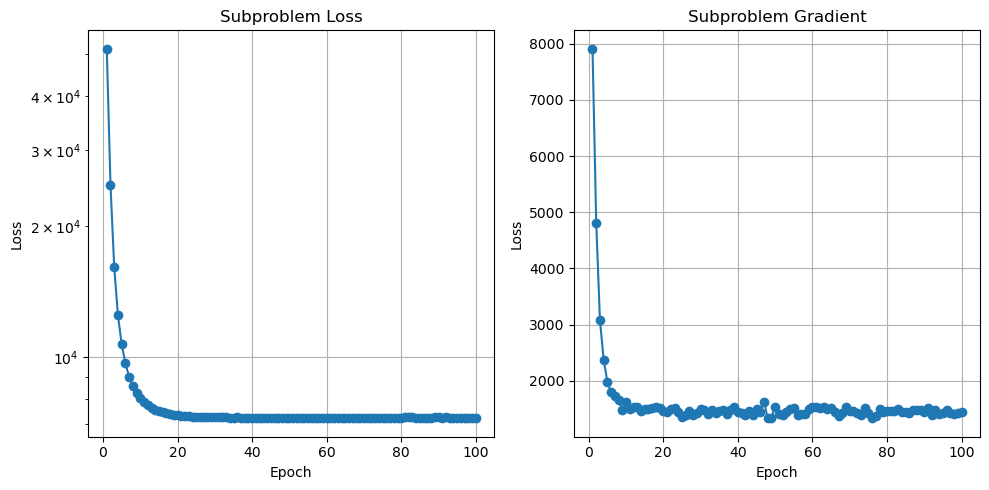

Final gradient of the subproblem (0, 1) : 1446.1856689453125
Separable Function
Iteration: 7, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95918.19876714688
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


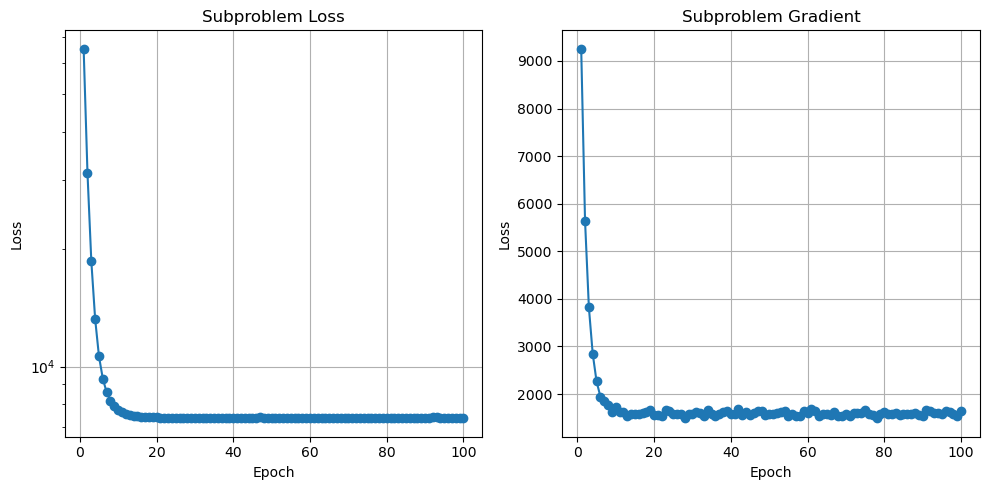

Final gradient of the subproblem (1, 0) : 1654.7176513671875
Separable Function
Iteration: 7, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 96002.49722382527
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


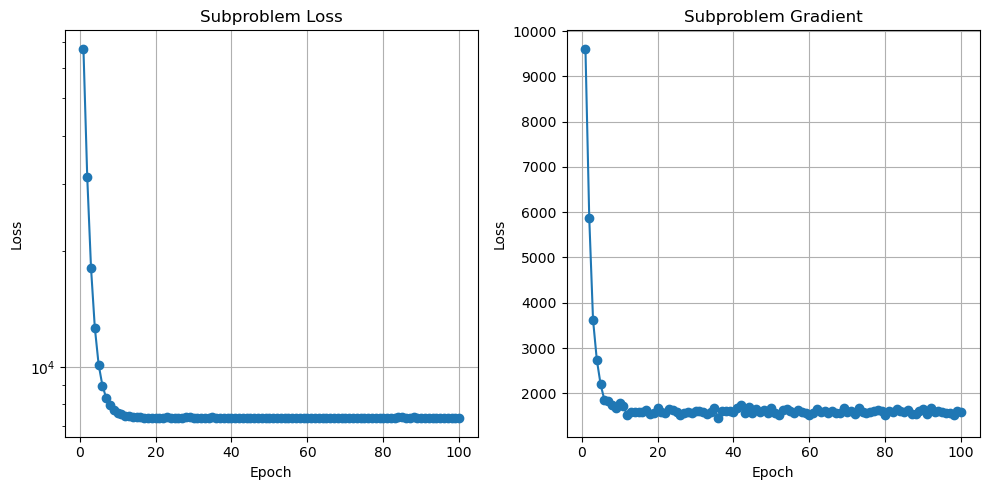

Final gradient of the subproblem (1, 1) : 1595.3905029296875
Separable Function
Iteration: 7, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95888.32337859942
---------------------------------------------Core-------------------------------------------------


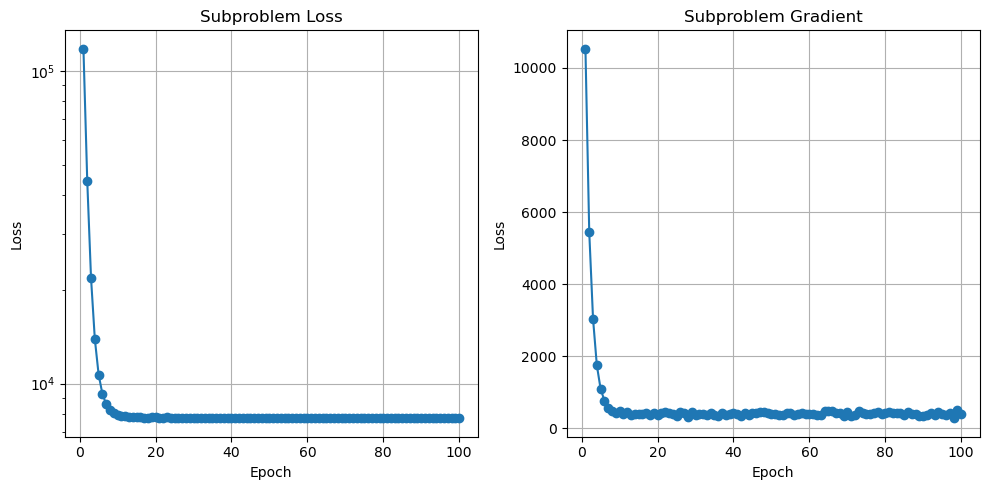

Final gradient of the subproblem Core : 410.6488342285156
Separable Function
--------------------------------------------------------------BCD iteration 8 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


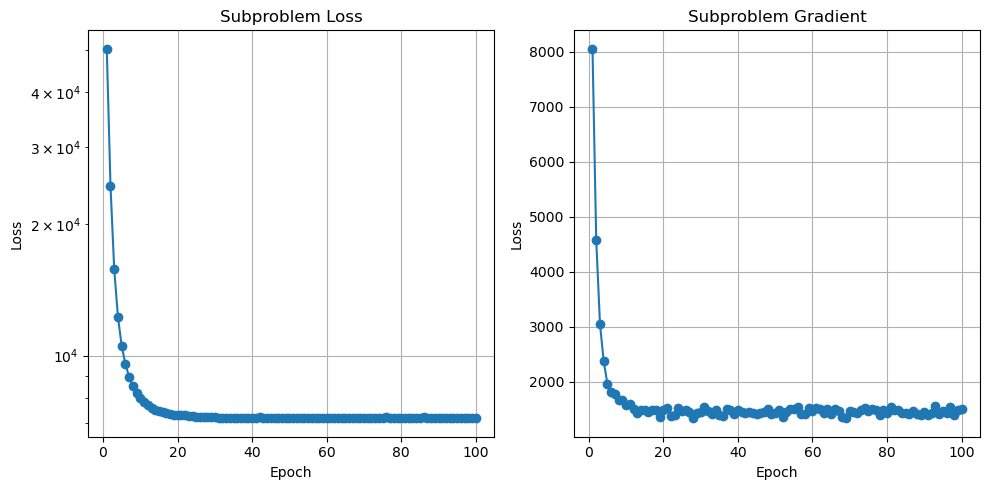

Final gradient of the subproblem (0, 0) : 1504.447998046875
Separable Function
Iteration: 8, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96040.21133965817
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


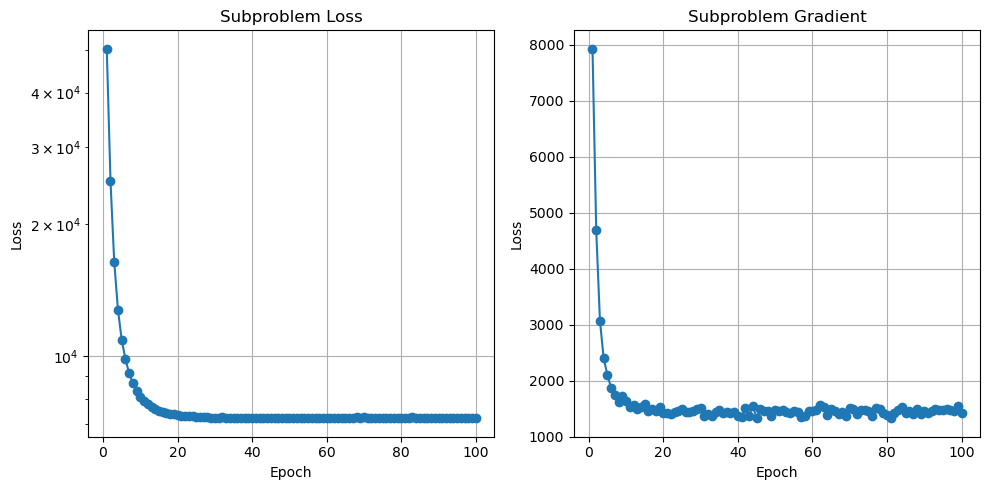

Final gradient of the subproblem (0, 1) : 1415.2188720703125
Separable Function
Iteration: 8, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 96009.89494071597
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


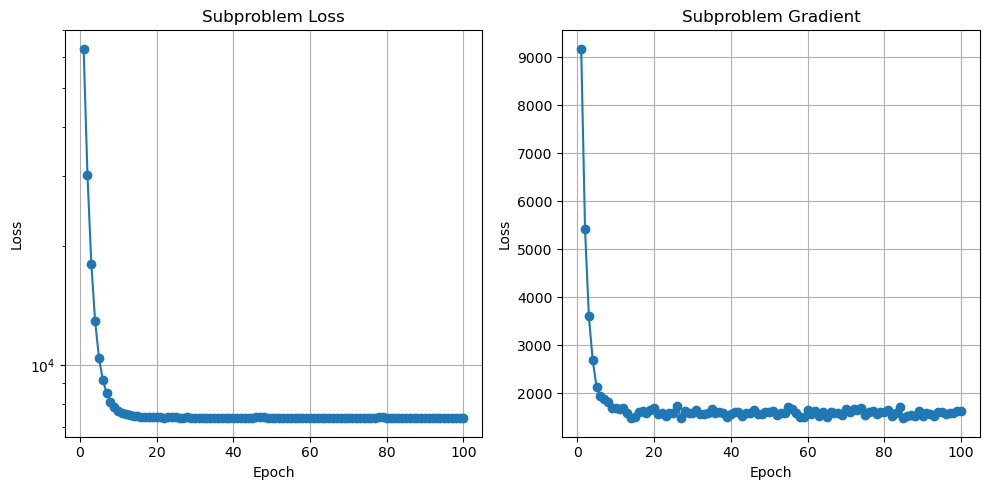

Final gradient of the subproblem (1, 0) : 1620.630126953125
Separable Function
Iteration: 8, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95993.82462329278
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


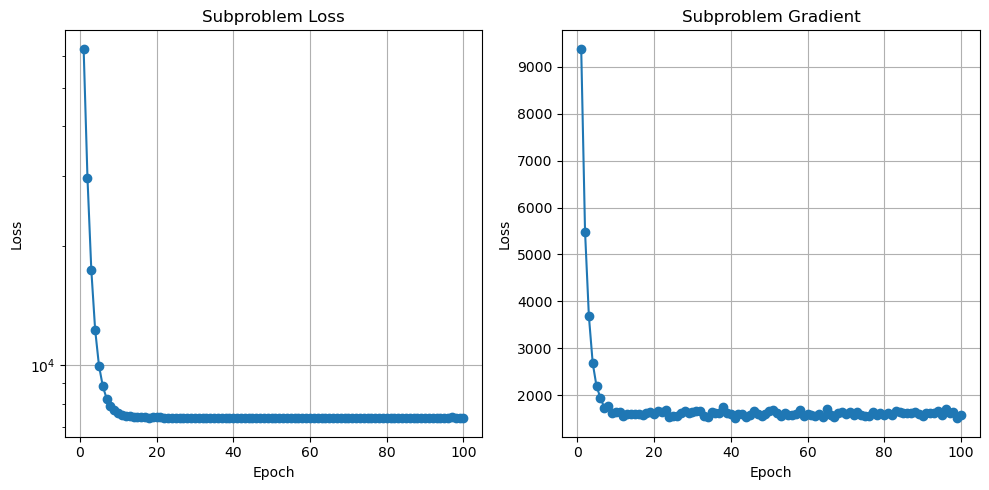

Final gradient of the subproblem (1, 1) : 1589.8531494140625
Separable Function
Iteration: 8, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95941.82441907548
---------------------------------------------Core-------------------------------------------------


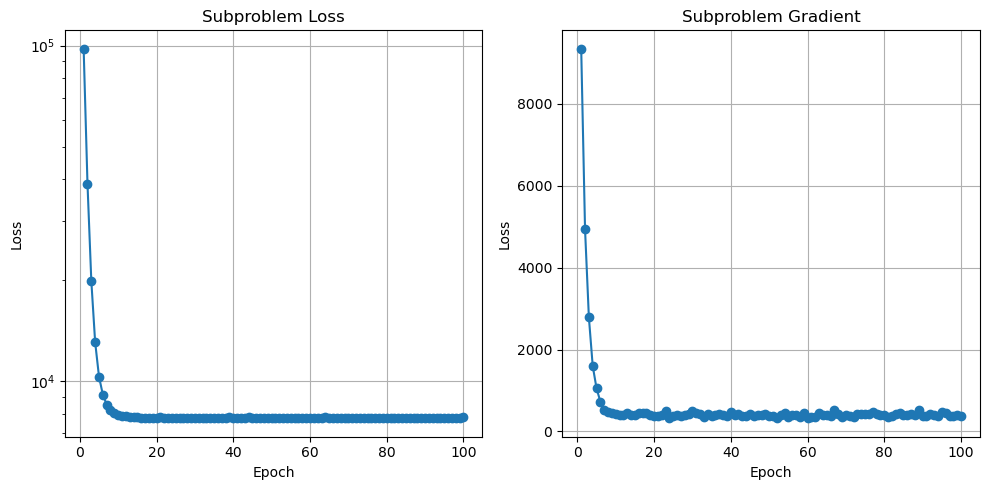

Final gradient of the subproblem Core : 379.8145751953125
Separable Function
--------------------------------------------------------------BCD iteration 9 --------------------------------------------------------------
---------------------------------------------Sep 0 Factor 0 -------------------------------------------------


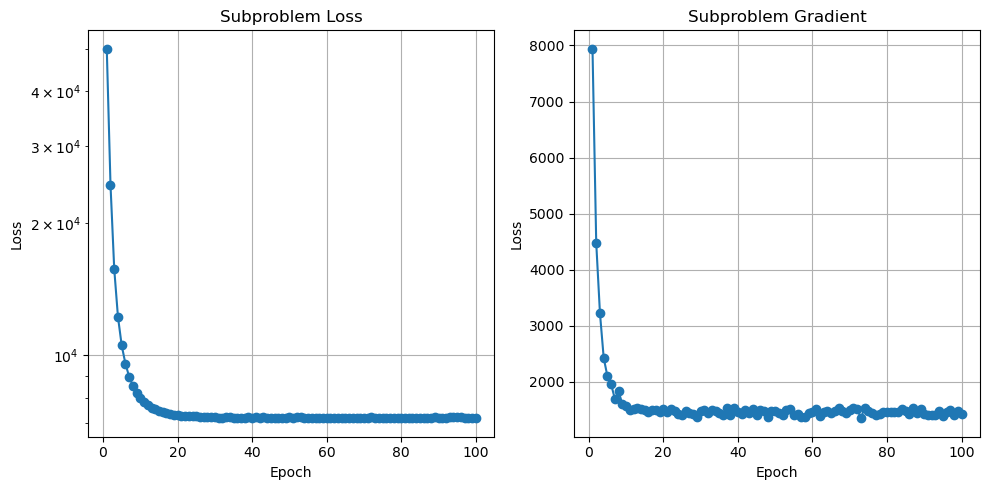

Final gradient of the subproblem (0, 0) : 1435.95361328125
Separable Function
Iteration: 9, Separation Rank: 0, Factor Matrix: 0, Objective Function Value: 96049.45229182637
---------------------------------------------Sep 0 Factor 1 -------------------------------------------------


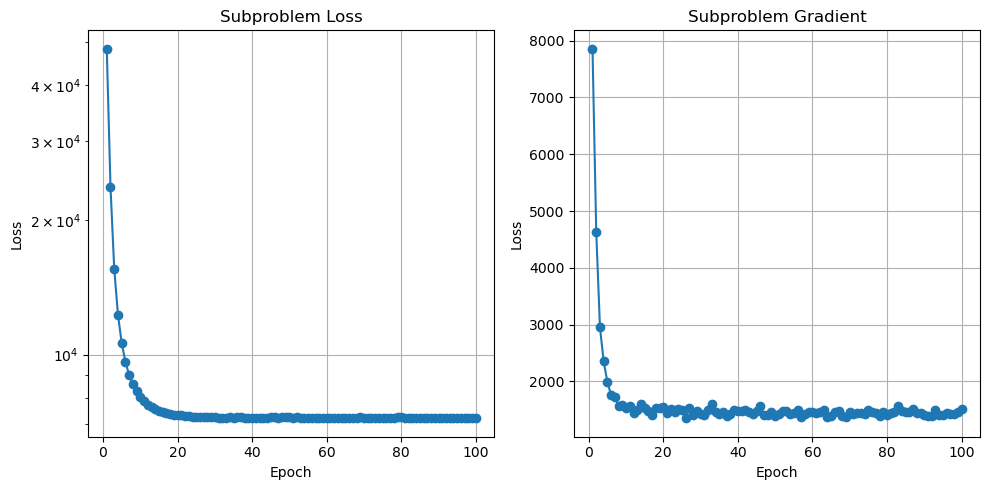

Final gradient of the subproblem (0, 1) : 1510.8848876953125
Separable Function
Iteration: 9, Separation Rank: 0, Factor Matrix: 1, Objective Function Value: 95962.29154807061
---------------------------------------------Sep 1 Factor 0 -------------------------------------------------


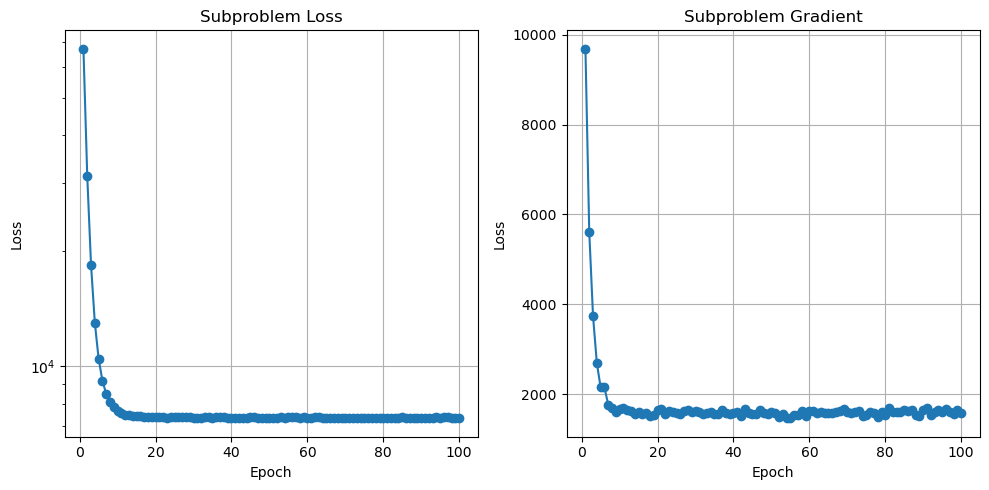

Final gradient of the subproblem (1, 0) : 1575.9393310546875
Separable Function
Iteration: 9, Separation Rank: 1, Factor Matrix: 0, Objective Function Value: 95978.38619257779
---------------------------------------------Sep 1 Factor 1 -------------------------------------------------


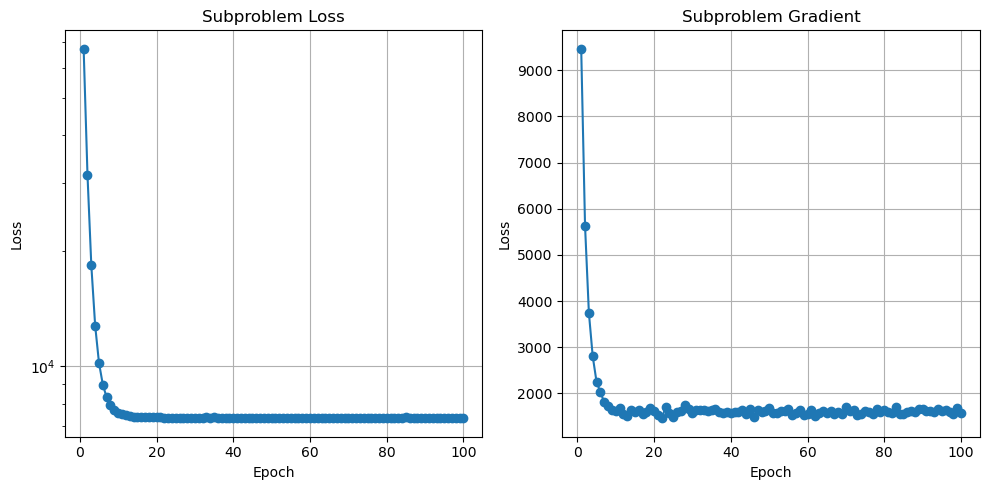

Final gradient of the subproblem (1, 1) : 1571.494140625
Separable Function
Iteration: 9, Separation Rank: 1, Factor Matrix: 1, Objective Function Value: 95985.8353719691
---------------------------------------------Core-------------------------------------------------


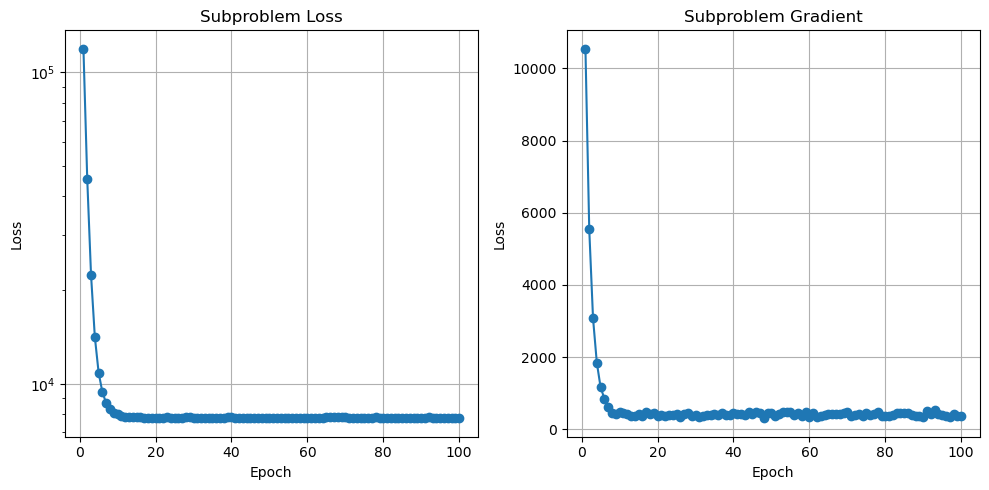

Final gradient of the subproblem Core : 364.16448974609375
Separable Function
(32, 32)
---------------------------Testing with Best Lambda------------------------------
Error Report on Testing _ With best Lambda
SGD_Alpha chosen for model:  50
SGD_Test Normalized Estimation Error:  0.05103948679415819
SGD_Test NMSE Loss:  0.003426353614510534
SGD_Test R2 Loss:  0.9524957078666876
SGD_Test Correlation:  0.9761372344994893


In [54]:
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_SGD_intermediate)
learning_rate = 0.00002
epochs = 100
batch_size = 64

momentum = 0
nesterov = False


hypers = {'max_iter': 10, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size, 'momentum':momentum, 'nesterov': nesterov}

normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Tensor_Method/Finding Lamda for Test/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("SGD_Alpha chosen for model: ", lambda1)
print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
print("SGD_Test Correlation: ", test_correlation_SGD)


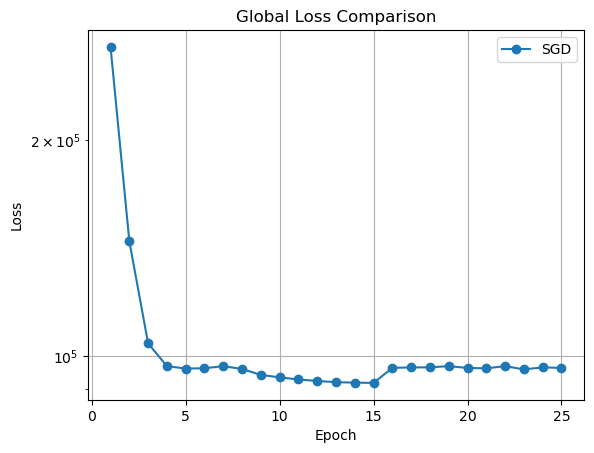

Final Objective Function Value SGD: [96206.09108134]


In [53]:
import matplotlib.pyplot as plt

# Plotting SGD Loss
# Plotting SGD Loss
objective_function_values_SGD_1 = objective_function_values_SGD__loaded[:, 1, 2].reshape(-1,1)

#concatanating the arrays
reshaped_array = objective_function_values_SGD[:, 1, 2].reshape(-1, 1)
# Concatenate along the first axis (rows)
objective_function_values_SGD_2 = np.concatenate((objective_function_values_SGD_1, reshaped_array), axis=0)

#plot SGD
plt.plot(range(1, len(objective_function_values_SGD_2) + 1), objective_function_values_SGD_2, label='SGD',marker = 'o')

# Plotting CLOSED
#plt.plot(range(1, len(objective_function_values) + 1), objective_function_values[:, 1, 2], label='CLOSED',marker = 'o')

# Plotting GD
#plt.plot(range(1, len(objective_function_values_GD) + 1), objective_function_values_GD[:, 1, 2], label='GD',marker = 'o')

# Setting the title and labels
plt.title('Global Loss Comparison')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adding a legend to distinguish the two plots
plt.legend()

# Display the plot
plt.show()

print('Final Objective Function Value SGD:',objective_function_values_SGD_2[-1])


In [19]:
import matplotlib.pyplot as plt


#All loss function values in one plot

plt.figure()

# Plotting SGD
plt.plot(range(1, len(objective_function_values_SGD) + 1), objective_function_values_SGD[:, 1, 2], label='SGD',marker = 'o')

# Plotting CLOSED
plt.plot(range(1, len(objective_function_values) + 1), objective_function_values[:, 1, 2], label='CLOSED',marker = 'o')

# Plotting GD
plt.plot(range(1, len(objective_function_values_GD) + 1), objective_function_values_GD[:, 1, 2], label='GD',marker = 'o')

# Setting the title and labels
plt.title('Global Loss Comparison')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adding a legend to distinguish the two plots
plt.legend()

# Display the plot
plt.show()

print('Final Objective Function Value CLOSED:',objective_function_values[-1,1,2])
print('Final Objective Function Value SGD:',objective_function_values_SGD[-1,1,2])
print('Final Objective Function Value GD:',objective_function_values_GD[-1,1,2])

ValueError: operands could not be broadcast together with shapes (50,) (10,) 